# 小文件初步数据处理

In [2]:
import pandas as pd
from datetime import datetime
import operator,jieba,re
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
from collections import Counter
%matplotlib inline

In [125]:
data = pd.read_excel(r"总理问答-一带一路.xlsx")
print(data.shape)
data.head()

(1371, 4)


,时间,职业,点赞数,具体内容
0,2017年03月15日,工人,1,#一带一路#电信宽带太贵了，可否能下降，根本用不起
1,2017年03月15日,学生,0,#一带一路#流量超出后，扣费扣到破产！
2,2017年03月15日,工人,1,#一带一路#免费领取流量
3,2017年03月15日,个体经营,0,#一带一路#流量还是贵
4,2017年03月15日,学生,0,#一带一路#流量贵阿


In [126]:
data['时间'] = data['时间'].str.replace("年","-")
data['时间'] = data['时间'].str.replace("月","-")
data['时间'] = data['时间'].str.replace("日","")
data['时间'] = pd.to_datetime(data['时间'])
data['具体内容'] = data['具体内容'].str.replace('#一带一路#','').replace("\t","").replace("\n","").replace("\r","")
cols=list(data.columns)
missing = list(map(lambda x:data[x].isnull().sum(),cols))
missing_dict = dict(zip(cols,missing))
missing_dict

{'具体内容': 7, '时间': 0, '点赞数': 0, '职业': 0}

In [127]:
cond1 = data['具体内容'].notnull()                      #非空
cond2 = data['具体内容'].str.contains(r"[一-龥]")       #必须含有中文
cond3 = data['具体内容'].str.contains(r"<b><\b>")       #非网页字符，此例中不包括
data = data.loc[cond1&cond2]
print (data.shape)
data.head()

(1364, 4)


,时间,职业,点赞数,具体内容
0,2017-03-15,工人,1,电信宽带太贵了，可否能下降，根本用不起
1,2017-03-15,学生,0,流量超出后，扣费扣到破产！
2,2017-03-15,工人,1,免费领取流量
3,2017-03-15,个体经营,0,流量还是贵
4,2017-03-15,学生,0,流量贵阿


In [128]:
data.to_csv("一带一路.txt",sep= "\t",encoding='utf-8',index=False)

# 小文件数据结果观察

In [36]:
df = pd.read_table("住有所居_result.txt",engine="python",encoding='utf-8')
df.head()

,时间,职业,点赞数,具体内容,polarity,magnitude,乐观,兴奋,喜爱,愉快,害羞,惊讶,焦虑,愤怒,恐惧,悲伤,厌恶
0,2017-03-15,工人,585,1.一个上学的孩子怎么轻易在网上就被贷上款了.2.网购信息怎么被别人知道了.3怎么支付宝的钱...,46.450,0.103,0.060,0.040,0.054,0.043,0.0,0.126,0.154,0.287,0.105,0.0,0.130
1,2017-03-15,工人,702,房价太高,20.132,0.078,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.467,0.260,0.0,0.273
2,2017-03-15,工人,366,房价真的太高了,47.678,0.101,0.187,0.124,0.107,0.058,0.0,0.000,0.000,0.302,0.100,0.0,0.121
3,2017-03-15,学生,181,住不起房,55.610,0.000,0.000,0.000,0.000,1.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000
4,2017-03-15,工人,89,各地方烂尾楼泛滥，政府和相关部门不予协调处理，消费者合法权益如何维护,31.039,0.251,0.365,0.000,0.000,0.000,0.0,0.000,0.000,0.307,0.000,0.0,0.328


In [37]:
df['职业'].value_counts()

工人      1539
公司职员     825
农民       550
学生       540
其他身份     479
教师医生     297
个体经营     204
城市务工     182
离退人员     128
公务员      108
军人        43
Name: 职业, dtype: int64

## 不同职业有不同的关注点

In [42]:
to_remove = ['，', '。', '、', '：', '…', '  ', '   ', '=', '“', '”', '【', '】', '\n', "、", "。", "〈", "〉", "《", "》","回复","允悲","cry","知道", "一",
                 "一切", "一则", "一方面", "一旦", "一来", "一样", "一般", "七", "万一", "三", "上下", "不仅", "不但", "不光", "不单", "不只", "不如",
                 "不怕", "不惟", "不成", "不拘", "不比", "不然", "不特", "不独", "不管", "不论", "不过", "不问", "与", "与其", "与否", "与此同时", "且",
                 "两者", "个", "临", "为", "为了", "为什么", "为何", "为着", "乃", "乃至", "么", "之", "之一", "之所以", "之类", "乌乎", "乎", "乘",
                 "九", "也", "也好", "也罢", "了", "二", "于", "于是", "于是乎", "云云", "五", "人家", "什么", "什么样", "从", "从而", "他", "他人",
                 "他们", "以", "以便", "以免", "以及", "以至", "以至于", "以致", "们", "任", "任何", "任凭", "似的", "但", "但是", "何", "何况", "何处",
                 "何时", "作为", "你", "你们", "使得", "例如", "依", "依照", "俺", "俺们", "倘", "倘使", "倘或", "倘然", "倘若", "借", "假使", "假如",
                 "假若", "像", "八", "六", "兮", "关于", "其", "其一", "其中", "其二", "其他", "其余", "其它", "其次", "具体地说", "具体说来", "再者",
                 "再说", "冒", "冲", "况且", "几", "几时", "凭", "凭借", "则", "别", "别的", "别说", "到", "前后", "前者", "加之", "即", "即令",
                 "即使", "即便", "即或", "即若", "又", "及", "及其", "及至", "反之", "反过来", "反过来说", "另", "另一方面", "另外", "只是", "只有", "只要",
                 "只限", "叫", "叮咚", "可", "可以", "可是", "可见", "各", "各个", "各位", "各种", "各自", "同", "同时", "向", "向着", "吓", "吗",
                 "否则", "吧", "吧哒", "吱", "呀", "呃", "呕", "呗", "呜", "呜呼", "呢", "呵", "呸", "呼哧", "咋", "和", "咚", "咦", "咱",
                 "咱们", "咳", "哇", "哈", "哈哈", "哉", "哎", "哎呀", "哎哟", "哗", "哟", "哦", "哩", "哪", "哪个", "哪些", "哪儿", "哪天", "哪年",
                 "哪怕", "哪样", "哪边", "哪里", "哼", "哼唷", "唉", "啊", "啐", "啥", "啦", "啪达", "喂", "喏", "喔唷", "嗡嗡", "嗬", "嗯", "嗳",
                 "嘎", "嘎登", "嘘", "嘛", "嘻", "嘿", "四", "因", "因为", "因此", "因而", "固然", "在", "在下", "地", "多", "多少", "她", "她们",
                 "如", "如上所述", "如何", "如其", "如果", "如此", "如若", "宁", "宁可", "宁愿", "宁肯", "它", "它们", "对", "对于", "将", "尔后",
                 "尚且", "就", "就是", "就是说", "尽", "尽管", "岂但", "己", "并", "并且", "开外", "开始", "归", "当", "当着", "彼", "彼此", "往",
                 "待", "得", "怎", "怎么", "怎么办", "怎么样", "怎样", "总之", "总的来看", "总的来说", "总的说来", "总而言之", "恰恰相反", "您", "慢说", "我",
                 "我们", "或", "或是", "或者", "所", "所以", "打", "把", "抑或", "拿", "按", "按照", "换句话说", "换言之", "据", "接着", "故", "故此",
                 "旁人", "无宁", "无论", "既", "既是", "既然", "时候", "是", "是的", "替", "有", "有些", "有关", "有的", "望", "朝", "朝着", "本",
                 "本着", "来", "来着", "极了", "果然", "果真", "某", "某个", "某些", "根据", "正如", "此", "此外", "此间", "毋宁", "每", "每当", "比",
                 "比如", "比方", "沿", "沿着", "漫说", "焉", "然则", "然后", "然而", "照", "照着", "甚么", "甚而", "甚至", "用", "由", "由于",
                 "由此可见", "的", "的话", "相对而言", "省得", "着", "着呢", "矣", "离", "第", "等", "等等", "管", "紧接着", "纵", "纵令", "纵使",
                 "纵然", "经", "经过", "结果", "给", "继而", "综上所述", "罢了", "者", "而", "而且", "而况", "而外", "而已", "而是", "而言", "能", "腾",
                 "自", "自个儿", "自从", "自各儿", "自家", "自己", "自身", "至", "至于", "若", "若是", "若非", "莫若", "虽", "虽则", "虽然", "虽说",
                 "被", "要", "要不", "要不是", "要不然", "要么", "要是", "让", "论", "设使", "设若", "该", "诸位", "谁", "谁知", "赶", "起", "起见",
                 "趁", "趁着", "越是", "跟", "较", "较之", "边", "过", "还是", "还有", "这", "这个", "这么", "这么些", "这么样", "这么点儿", "这些",
                 "这会儿", "这儿", "这就是说", "这时", "这样", "这边", "这里", "进而", "连", "连同", "通过", "遵照", "那", "那个", "那么", "那么些",
                 "那么样", "那些", "那会儿", "那儿", "那时", "那样", "那边", "那里", "鄙人", "鉴于", "阿", "除", "除了", "除此之外", "除非", "随", "随着",
                 "零", "非但", "非徒", "靠", "顺", "顺着","不会","不想", "首先","您好","你好","没有","不是", "已经","请问","谢谢","很多","现在","不能",
                 "一个","还要","应该","一下","总理","一名","一次","...",
                 "︿", "！", "＃", "＄", "％", "＆", "（", "）", "＊", "＋", "，", "０", "１",
                 "２", "３", "４", "５", "６", "７", "８", "９", "：", "；", "＜", "＞", "？", "＠", "［", "］", "｛", "｜", "｝", "～",
                 "￥"]

In [43]:
content = df['具体内容'].to_string(index=False,header=False).replace("\n","")
words = [w for w in list(jieba.cut(content)) if (w not in to_remove)&(len(w)>1)]
Counter(words).most_common(10)

[('房价', 1909),
 ('房子', 744),
 ('农村', 388),
 ('希望', 386),
 ('工资', 369),
 ('政府', 362),
 ('问题', 316),
 ('买不起', 281),
 ('太高', 273),
 ('城市', 273)]

In [44]:
jobs = list(df['职业'].value_counts().index)
jobs

['工人', '公司职员', '农民', '学生', '其他身份', '教师医生', '个体经营', '城市务工', '离退人员', '公务员', '军人']

In [45]:
for job in jobs:
    cond = df['职业']==job
    content = df['具体内容'].loc[cond]
    content = content.apply(lambda s: [i for i in list(jieba.cut(s)) if (i not in to_remove)&(len(i)>1)])
    content.index = range(len(content))
    words_dict = {}
    for i in range(len(content)):
        for w in content.loc[i]:
            if w in words_dict:words_dict[w]+=1
            else:words_dict[w] = 1
    sorted_dict = sorted(words_dict.items(),key=operator.itemgetter(1))
    sorted_dict.reverse()
    print(job,":",*next(iter(zip(*sorted_dict)))[:20],"\n"+"-"*120+"\n")

工人 : 房价 房子 政府 希望 老百姓 问题 工资 国家 农村 城市 买不起 解决 太高 政策 开发商 生活 业主 买房 一直 住房 
------------------------------------------------------------------------------------------------------------------------

公司职员 : 房价 房子 希望 政府 工资 国家 问题 买房 工作 买不起 城市 政策 生活 解决 老百姓 孩子 农村 住房 太高 公积金 
------------------------------------------------------------------------------------------------------------------------

农民 : 农民 农村 房子 房价 政府 土地 希望 老百姓 问题 政策 解决 国家 宅基地 生活 拆迁 村民 领导 业主 中国 红旗 
------------------------------------------------------------------------------------------------------------------------

学生 : 房价 希望 房子 农村 问题 大学生 学生 国家 毕业 城市 买房 压力 政府 太高 解决 工资 真的 买不起 政策 一些 
------------------------------------------------------------------------------------------------------------------------

其他身份 : 房价 房子 国家 希望 问题 政府 政策 工作 工资 老百姓 解决 农村 人员 房屋 社会 孩子 买房 生活 城市 单位 
------------------------------------------------------------------------------------------------------------------------

教师医生 : 房价 教师 房子 工资 国家 工作 问题 希望 教育 解决 政府 孩子 职称

## 意见领袖反馈了什么问题

In [46]:
df.sort_values("点赞数",ascending=False)[:10]

,时间,职业,点赞数,具体内容,polarity,magnitude,乐观,兴奋,喜爱,愉快,害羞,惊讶,焦虑,愤怒,恐惧,悲伤,厌恶
4893,2017-02-22,军人,9138,总理您好，请问打虎拍蝇反腐什么时候能够推到农村，我们期待已久，谢谢！,74.067,0.495,0.491,0.000,0.509,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000
4832,2017-02-28,公司职员,4829,房价什么时候能降,19.863,0.049,0.000,0.000,0.000,0.000,0.0,0.000,0.239,0.462,0.000,0.0,0.299
813,2017-03-13,其他身份,713,总理您好，我是南京市鼓楼区宁工新寓一村的一位普通居民，本来家门口新建的南京地铁四号线可以给生...,68.369,0.233,0.230,0.133,0.189,0.131,0.0,0.051,0.047,0.114,0.050,0.0,0.054
1,2017-03-15,工人,702,房价太高,20.132,0.078,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.467,0.260,0.0,0.273
0,2017-03-15,工人,585,1.一个上学的孩子怎么轻易在网上就被贷上款了.2.网购信息怎么被别人知道了.3怎么支付宝的钱...,46.450,0.103,0.060,0.040,0.054,0.043,0.0,0.126,0.154,0.287,0.105,0.0,0.130
2,2017-03-15,工人,366,房价真的太高了,47.678,0.101,0.187,0.124,0.107,0.058,0.0,0.000,0.000,0.302,0.100,0.0,0.121
3,2017-03-15,学生,181,住不起房,55.610,0.000,0.000,0.000,0.000,1.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000
4,2017-03-15,工人,89,各地方烂尾楼泛滥，政府和相关部门不予协调处理，消费者合法权益如何维护,31.039,0.251,0.365,0.000,0.000,0.000,0.0,0.000,0.000,0.307,0.000,0.0,0.328
4894,2017-02-22,军人,82,李克强总理，羊年为人民保重好身体，多打虎拍蝇，为民办实事，2015年政府是否会坚持打虎拍蝇力...,67.686,0.279,0.266,0.109,0.187,0.150,0.0,0.000,0.000,0.103,0.079,0.0,0.105
4649,2017-03-01,其他身份,76,请问总理，为了减轻国家负担，大办粮食，促进农业生产，积极响应国家号召，上世纪60年代初五七年...,67.638,0.313,1.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000


## 提问的积极性

In [47]:
df['时间'] = pd.to_datetime(df['时间'])
df['时间'] = df['时间'].dt.strftime("%Y-%m-%d")
df['时间'].value_counts()

2017-03-06    633
2017-03-09    460
2017-03-14    420
2017-03-10    405
2017-03-12    336
2017-03-13    325
2017-03-07    321
2017-03-11    309
2017-03-05    305
2017-03-08    278
2017-03-01    261
2017-03-03    219
2017-03-02    196
2017-03-04    180
2017-03-15    179
2017-02-28     39
2017-02-24     22
2017-02-22      3
2017-02-23      3
2017-02-27      1
Name: 时间, dtype: int64

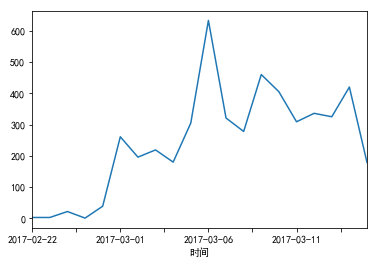

In [48]:
df.groupby(['时间']).size().plot(kind='line')

In [49]:
times = df['时间'].value_counts().index.sort_values()
times

Index(['2017-02-22', '2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28',
       '2017-03-01', '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',
       '2017-03-06', '2017-03-07', '2017-03-08', '2017-03-09', '2017-03-10',
       '2017-03-11', '2017-03-12', '2017-03-13', '2017-03-14', '2017-03-15'],
      dtype='object')

In [50]:
for time in times:
    cond = df['时间']==time
    content = df['具体内容'].loc[cond]
    content = content.apply(lambda s: [i for i in list(jieba.cut(s)) if (i not in to_remove)&(len(i)>1)])
    content.index = range(len(content))
    words_dict = {}
    for i in range(len(content)):
        for w in content.loc[i]:
            if w in words_dict:words_dict[w]+=1
            else:words_dict[w] = 1
    sorted_dict = sorted(words_dict.items(),key=operator.itemgetter(1))
    sorted_dict.reverse()
    print(time,":",*next(iter(zip(*sorted_dict)))[:5],"\n"+"-"*120+"\n")

2017-02-22 : 拍蝇 打虎 人民 农村 社会 
------------------------------------------------------------------------------------------------------------------------

2017-02-23 : 教育经费 划拨 学校 国家 工资 
------------------------------------------------------------------------------------------------------------------------

2017-02-24 : 治理 污染 国家 中国 社会 
------------------------------------------------------------------------------------------------------------------------

2017-02-27 : 好多 购物 网络 经济损失 老百姓 
------------------------------------------------------------------------------------------------------------------------

2017-02-28 : 建设 房价 加快 联网 电力 
------------------------------------------------------------------------------------------------------------------------

2017-03-01 : 房价 房子 政府 问题 希望 
------------------------------------------------------------------------------------------------------------------------

2017-03-02 : 房价 房子 问题 希望 政府 
------------------------------------------------------------

## 态度积极/消极的留言

In [51]:
df.sort_values("polarity",ascending=False)[:10]

,时间,职业,点赞数,具体内容,polarity,magnitude,乐观,兴奋,喜爱,愉快,害羞,惊讶,焦虑,愤怒,恐惧,悲伤,厌恶
4386,2017-03-02,工人,12,总理房价都导致大家伙娶不起媳妇这可是很严重的民生问题,91.785,0.603,1.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000
1630,2017-03-10,工人,0,房产税要推出，多建立廉租房，,90.249,0.713,1.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000
4492,2017-03-02,工人,0,祝愿我们国家越来越好,90.121,0.722,0.292,0.000,0.368,0.242,0.0,0.000,0.0,0.051,0.015,0.0,0.033
2162,2017-03-09,农民,0,希望多关注农村养老住房条件,90.110,0.731,0.509,0.000,0.491,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000
1227,2017-03-12,工人,1,房企的利润是多少,90.000,0.700,1.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000
3776,2017-03-05,工人,0,烂尾楼，烂尾楼，烂尾楼啥时候解决？,90.000,0.700,0.000,1.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000
508,2017-03-14,学生,0,学习压力大了,90.000,0.700,0.526,0.000,0.474,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000
1713,2017-03-10,工人,0,人民住房难啊,90.000,0.700,0.552,0.000,0.448,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000
1145,2017-03-12,学生,0,最近物价上涨的太厉害了。,89.232,0.639,0.223,0.221,0.314,0.134,0.0,0.019,0.0,0.059,0.000,0.0,0.029
589,2017-03-14,工人,0,希望廉租房能得到落实,89.192,0.525,1.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000


In [52]:
df.sort_values("polarity")[:10]

,时间,职业,点赞数,具体内容,polarity,magnitude,乐观,兴奋,喜爱,愉快,害羞,惊讶,焦虑,愤怒,恐惧,悲伤,厌恶
1394,2017-03-11,学生,1,房价实在是太贵了,5.466,0.922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.659,0.0,0.0,0.341
1381,2017-03-11,工人,0,医疗保险越来越贵,6.250,1.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591,0.0,0.0,0.409
511,2017-03-14,公务员,0,房太贵了,7.496,0.612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.615,0.0,0.0,0.385
2281,2017-03-09,学生,0,为什么房子这么贵,8.686,0.485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.656,0.0,0.0,0.344
1516,2017-03-11,工人,1,现在房价是一个劲的涨，工资幅度太小，完全没法比。,8.895,0.508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.630,0.0,0.0,0.370
1908,2017-03-10,工人,0,为何农民买房这么难 房票这么贵根本买不起,8.987,0.498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470,0.0,0.0,0.530
2132,2017-03-09,工人,0,房价为什么这么贵,9.002,0.515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.617,0.0,0.0,0.383
489,2017-03-14,工人,0,取消读书房，贵的离谱,9.072,0.481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.545,0.0,0.0,0.455
2510,2017-03-08,农民,0,房子太贵了买不起,9.123,0.444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.422,0.0,0.0,0.578
314,2017-03-14,工人,1,房价为啥这么贵,9.404,0.477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.550,0.0,0.0,0.450


In [53]:
df.polarity.mean()

46.82825515832483

In [54]:
df["情绪max"] = df[['乐观', '兴奋', '喜爱','愉快', '害羞', '惊讶', '焦虑', '愤怒', '恐惧', '悲伤', '厌恶']].idxmax(axis = 1)
df['情绪max'].value_counts()/len(df) * 100

乐观    46.230848
愤怒    39.632278
厌恶     7.109295
喜爱     3.718080
焦虑     1.348315
恐惧     1.266599
愉快     0.347293
兴奋     0.163432
悲伤     0.102145
惊讶     0.061287
害羞     0.020429
Name: 情绪max, dtype: float64

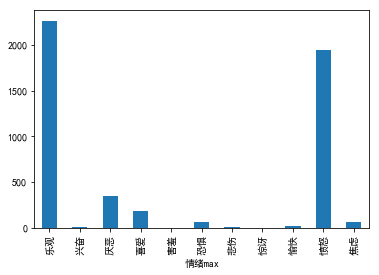

In [55]:
df.groupby(['情绪max']).size().plot(kind='bar')

# 加问题标签

In [140]:
doc = pd.read_table("./result/其他问题_result.txt",engine='python',encoding='utf-8')
doc['话题'] = "其他问题"
doc.to_csv("./result/其他问题_result.txt",sep= "\t",encoding='utf-8',index=False)

# 文件合并

In [4]:
%pwd

'C:\\Users\\Kismet\\Documents\\我的坚果云\\语忆科技有限公司\\袁晋总理问答'

In [5]:
%cd point

C:\Users\Kismet\Documents\我的坚果云\语忆科技有限公司\袁晋总理问答\point


In [59]:
import os
import glob

mergedir = os.getcwd()
filenames = os.listdir(mergedir)
for filename in filenames:
    doc = pd.read_table(filename,engine="python",encoding='utf-8')
    doc.to_csv("point.txt",mode='a+',sep="\t",header=False,index = False,encoding = 'utf-8')

# 综合文件读入分析

In [6]:
df = pd.read_table("point.txt",names=['时间', '职业', '点赞数', '具体内容', 'polarity', 'magnitude', '乐观', '兴奋', '喜爱',
       '愉快', '害羞', '惊讶', '焦虑', '愤怒', '恐惧', '悲伤', '厌恶', '话题','观点'])
df.head()

,时间,职业,点赞数,具体内容,polarity,magnitude,乐观,兴奋,喜爱,愉快,害羞,惊讶,焦虑,愤怒,恐惧,悲伤,厌恶,话题,观点
0,2017-03-15,工人,1,电信宽带太贵了，可否能下降，根本用不起,21.976,0.585,0.0,0.0,0.000,0.000,0.0,0.0,0.247,0.481,0.0,0.0,0.271,一带一路,None
1,2017-03-15,学生,0,流量超出后，扣费扣到破产！,31.670,0.295,0.0,0.0,0.000,0.000,0.0,0.0,0.000,1.000,0.0,0.0,0.000,一带一路,None
2,2017-03-15,工人,1,免费领取流量,82.051,0.263,0.0,0.0,0.474,0.526,0.0,0.0,0.000,0.000,0.0,0.0,0.000,一带一路,None
3,2017-03-15,个体经营,0,流量还是贵,17.432,0.622,0.0,0.0,0.000,0.000,0.0,0.0,0.237,0.496,0.0,0.0,0.267,一带一路,None
4,2017-03-15,学生,0,流量贵阿,21.019,0.240,0.0,0.0,0.000,0.000,0.0,0.0,0.237,0.496,0.0,0.0,0.267,一带一路,None


In [61]:
df.shape

(33586, 19)

In [62]:
df['话题'].value_counts()

其他问题    5824
教育改革    5652
住有所居    4895
老有所养    4428
病有所医    3163
食品安全    2844
精准扶贫    2251
生态环保    1937
一带一路    1364
外交军事    1228
Name: 话题, dtype: int64

## 观点提取

In [42]:
import requests,json,re
import urllib.request

def send_request(text,type):
    try:
        response = requests.post(
            url="https://aip.baidubce.com/rpc/2.0/nlp/v2/comment_tag",
            params={
                "access_token": "24.fded1baeb0b0231e6926bc58b28234b8.2592000.1515810833.282335-10525908",
            },
            headers={
                "Cookie": "BAIDUID=0F4BD41B1D4168198362C68C03F5B005:FG=1",
                "Content-Type": "application/json; charset=gbk",
            },
            data=json.dumps({
                "type": type,
                "text": text
            })
        )
        p = re.findall(r"<span>(.*?)</span>",response.text,re.M|re.I)
        return p[0]
    except requests.exceptions.RequestException:
        print('HTTP Request failed')

## 留言评论量随时间变化

In [7]:
df['时间'] = pd.to_datetime(df['时间'])

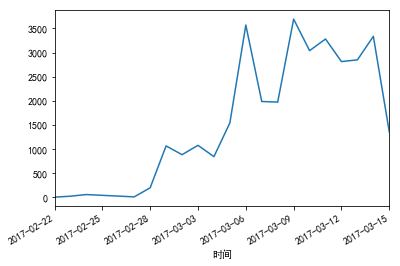

In [8]:
df.groupby(['时间']).size().plot(kind='line')

In [10]:
df.groupby(['时间']).size().to_excel("time.xlsx")

## 参与的职业分布

In [15]:
df['职业'].value_counts()

工人      9686
学生      7380
农民      3810
公司职员    3331
其他身份    3149
教师医生    2635
个体经营    1157
城市务工     895
公务员      674
离退人员     645
军人       224
Name: 职业, dtype: int64

## 涉及话题

In [16]:
df['话题'].value_counts()

其他问题    5824
教育改革    5652
住有所居    4895
老有所养    4428
病有所医    3163
食品安全    2844
精准扶贫    2251
生态环保    1937
一带一路    1364
外交军事    1228
Name: 话题, dtype: int64

## 点赞数最多的内容/话题

In [11]:
likes = df.sort_values("点赞数",ascending=False)[:10]
likes

,时间,职业,点赞数,具体内容,polarity,magnitude,乐观,兴奋,喜爱,愉快,害羞,惊讶,焦虑,愤怒,恐惧,悲伤,厌恶,话题
30724,2017-02-28,离退人员,12650,请总理尽快解决养老金不公平的问题！！！,33.171,0.448,0.390000,0.000000,0.000000,0.000000,0.0,0.00000,0.302000,0.308000,0.00,0.0,0.000000,老有所养
23726,2017-03-05,离退人员,12135,李总理您好：我国国家这些罕见病的病人这么多，长期忍受着病痛的折磨，甚至还面临着生命的威胁，希...,56.240,0.361,0.504000,0.000000,0.496000,0.000000,0.0,0.00000,0.000000,0.000000,0.00,0.0,0.000000,病有所医
6257,2017-02-22,军人,9138,总理您好，请问打虎拍蝇反腐什么时候能够推到农村，我们期待已久，谢谢！,74.067,0.495,0.491000,0.000000,0.509000,0.000000,0.0,0.00000,0.000000,0.000000,0.00,0.0,0.000000,住有所居
30716,2017-02-28,离退人员,8829,尽快动真格地解决“退休双轨制”所造成的悬殊待遇差！！！,26.522,0.197,0.312000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.391000,0.00,0.0,0.297000,老有所养
6196,2017-02-28,公司职员,4829,房价什么时候能降,19.863,0.049,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.239000,0.462000,0.00,0.0,0.299000,住有所居
33585,2017-02-24,工人,4777,建议实行全国免费养老体系，让所有老人安享晚年！,78.308,0.293,0.553000,0.000000,0.447000,0.000000,0.0,0.00000,0.000000,0.000000,0.00,0.0,0.000000,食品安全
18927,2017-03-01,教师医生,3243,总理您好，教师职称工资今年能彻底改革吗？,60.369,0.329,0.575000,0.000000,0.425000,0.000000,0.0,0.00000,0.000000,0.000000,0.00,0.0,0.000000,教育改革
1363,2017-02-24,工人,2242,请问总理，没有地的，农民怎么解决,65.038,0.243,0.256436,0.104061,0.167241,0.122643,0.0,0.08179,0.094503,0.091961,0.00,0.0,0.081366,一带一路
2177,2017-03-13,其他身份,713,总理您好，我是南京市鼓楼区宁工新寓一村的一位普通居民，本来家门口新建的南京地铁四号线可以给生...,68.369,0.233,0.230000,0.133000,0.189000,0.131000,0.0,0.05100,0.047000,0.114000,0.05,0.0,0.054000,住有所居
1365,2017-03-15,工人,702,房价太高,20.132,0.078,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.467000,0.26,0.0,0.273000,住有所居


In [13]:
likes.to_excel("time.xlsx")

In [21]:
likes['话题'].value_counts()

住有所居    4
老有所养    2
教育改革    1
食品安全    1
一带一路    1
病有所医    1
Name: 话题, dtype: int64

## 最长留言字数

In [14]:
df['具体内容'].str.len().max()

606

In [16]:
cond = df['具体内容'].str.len()==606
df.loc[cond]

,时间,职业,点赞数,具体内容,polarity,magnitude,乐观,兴奋,喜爱,愉快,害羞,惊讶,焦虑,愤怒,恐惧,悲伤,厌恶,话题
26312,2017-02-28,教师医生,0,#精准扶贫#作为一个从09年三支一扶，支援山区的大学生，到现在服务于基层街道办事处的工作人员...,63.386,0.198,0.238,0.117,0.167,0.112,0.0,0.0,0.068,0.139,0.077,0.0,0.082,精准扶贫


In [18]:
df.loc[cond].to_excel("time.xlsx")

## 各个话题留言职业分布

In [19]:
df.groupby(["话题","职业"]).具体内容.count()

话题    职业  
一带一路  个体经营      51
      公务员       15
      公司职员     142
      其他身份     113
      军人         6
      农民       101
      城市务工      21
      学生       441
      工人       403
      教师医生      59
      离退人员      12
住有所居  个体经营     204
      公务员      108
      公司职员     825
      其他身份     479
      军人        43
      农民       550
      城市务工     182
      学生       540
      工人      1539
      教师医生     297
      离退人员     128
其他问题  个体经营     240
      公务员      140
      公司职员     513
      其他身份     812
      军人        52
      农民       894
      城市务工     195
      学生       911
              ... 
精准扶贫  其他身份     207
      军人        11
      农民       569
      城市务工      86
      学生       525
      工人       576
      教师医生      58
      离退人员       5
老有所养  个体经营     106
      公务员       83
      公司职员     370
      其他身份     425
      军人        11
      农民       576
      城市务工     117
      学生       451
      工人      1663
      教师医生     404
      离退人员     222
食品安全  个体经营     134
      公务员       66
 

In [20]:
df.groupby(["话题","职业"]).具体内容.count().to_excel("time.xlsx")

## 各个话题polarity

In [47]:
df.groupby("话题").polarity.mean()

话题
一带一路    47.677295
住有所居    46.828255
其他问题    48.254480
外交军事    54.922825
教育改革    52.530953
生态环保    45.738692
病有所医    43.496501
精准扶贫    63.279147
老有所养    51.238063
食品安全    48.336267
Name: polarity, dtype: float64

In [61]:
df.groupby("话题").polarity.std()

话题
一带一路    24.707159
住有所居    18.729321
其他问题    17.914656
外交军事    20.782120
教育改革    18.341949
生态环保    22.675245
病有所医    21.065147
精准扶贫    17.753079
老有所养    19.426881
食品安全    22.922291
Name: polarity, dtype: float64

## 针对各话题，不同职业的polarity

In [22]:
df.groupby(['话题','职业']).polarity.mean()

话题    职业  
一带一路  个体经营    51.956647
      公务员     48.084533
      公司职员    53.921035
      其他身份    49.422788
      军人      37.500333
      农民      46.672772
      城市务工    42.182476
      学生      45.258050
      工人      47.757303
      教师医生    47.539492
      离退人员    48.717083
住有所居  个体经营    47.093980
      公务员     49.281093
      公司职员    47.137239
      其他身份    47.372837
      军人      54.301419
      农民      47.713491
      城市务工    43.627863
      学生      47.969909
      工人      45.609277
      教师医生    47.910842
      离退人员    45.870055
其他问题  个体经营    47.689913
      公务员     55.170986
      公司职员    49.074131
      其他身份    48.793493
      军人      53.437865
      农民      47.099314
      城市务工    47.101533
      学生      48.494270
                ...    
精准扶贫  其他身份    61.289773
      军人      60.501909
      农民      61.027527
      城市务工    61.087081
      学生      65.552126
      工人      63.534253
      教师医生    69.272431
      离退人员    61.353400
老有所养  个体经营    53.079123
      公务员     52.991361
     

In [24]:
df.groupby(['话题','职业']).polarity.mean().to_excel("time.xlsx")

## 最大概率情绪种类

In [5]:
df["情绪max"] = df[['乐观', '兴奋', '喜爱','愉快', '害羞', '惊讶', '焦虑', '愤怒', '恐惧', '悲伤', '厌恶']].idxmax(axis = 1)
df.head()

,时间,职业,点赞数,具体内容,polarity,magnitude,乐观,兴奋,喜爱,愉快,害羞,惊讶,焦虑,愤怒,恐惧,悲伤,厌恶,话题,情绪max
0,2017-03-15,工人,1,电信宽带太贵了，可否能下降，根本用不起,21.976,0.585,0.0,0.0,0.000,0.000,0.0,0.0,0.247,0.481,0.0,0.0,0.271,一带一路,愤怒
1,2017-03-15,学生,0,流量超出后，扣费扣到破产！,31.670,0.295,0.0,0.0,0.000,0.000,0.0,0.0,0.000,1.000,0.0,0.0,0.000,一带一路,愤怒
2,2017-03-15,工人,1,免费领取流量,82.051,0.263,0.0,0.0,0.474,0.526,0.0,0.0,0.000,0.000,0.0,0.0,0.000,一带一路,愉快
3,2017-03-15,个体经营,0,流量还是贵,17.432,0.622,0.0,0.0,0.000,0.000,0.0,0.0,0.237,0.496,0.0,0.0,0.267,一带一路,愤怒
4,2017-03-15,学生,0,流量贵阿,21.019,0.240,0.0,0.0,0.000,0.000,0.0,0.0,0.237,0.496,0.0,0.0,0.267,一带一路,愤怒


In [27]:
df.groupby("话题").情绪max.value_counts()

话题    情绪max
一带一路  愤怒        596
      乐观        517
      喜爱        101
      厌恶         85
      愉快         31
      焦虑         22
      恐惧         10
      兴奋          1
      惊讶          1
住有所居  乐观       2263
      愤怒       1940
      厌恶        348
      喜爱        182
      焦虑         66
      恐惧         62
      愉快         17
      兴奋          8
      悲伤          5
      惊讶          3
      害羞          1
其他问题  乐观       2622
      愤怒       2073
      厌恶        562
      喜爱        404
      焦虑         72
      恐惧         66
      愉快         18
      惊讶          5
      悲伤          2
外交军事  乐观        549
               ... 
病有所医  悲伤          5
      惊讶          5
      害羞          1
精准扶贫  乐观       1448
      愤怒        391
      喜爱        236
      厌恶        157
      恐惧         11
      焦虑          7
      愉快          1
老有所养  乐观       2275
      愤怒       1297
      厌恶        360
      喜爱        333
      焦虑         82
      恐惧         41
      愉快         21
      悲伤          8
      害羞

In [28]:
df.groupby("话题").情绪max.value_counts().to_excel("time.xlsx")

## 不同话题的意见领袖

In [35]:
k = df.groupby("话题").点赞数.max().index
v = df.groupby("话题").点赞数.max().values
for k,v in zip(k,v):
    cond1 = df["话题"] == k
    cond2 = df["点赞数"] == v
    print (df.loc[cond1&cond2].to_string())

             时间  职业   点赞数              具体内容  polarity  magnitude        乐观        兴奋        喜爱        愉快   害羞       惊讶        焦虑        愤怒   恐惧   悲伤        厌恶    话题 情绪max
1363 2017-02-24  工人  2242  请问总理，没有地的，农民怎么解决    65.038      0.243  0.256436  0.104061  0.167241  0.122643  0.0  0.08179  0.094503  0.091961  0.0  0.0  0.081366  一带一路    乐观
             时间  职业   点赞数                                具体内容  polarity  magnitude     乐观   兴奋     喜爱   愉快   害羞   惊讶   焦虑   愤怒   恐惧   悲伤   厌恶    话题 情绪max
6257 2017-02-22  军人  9138  总理您好，请问打虎拍蝇反腐什么时候能够推到农村，我们期待已久，谢谢！    74.067      0.495  0.491  0.0  0.509  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  住有所居    喜爱
             时间    职业  点赞数                                               具体内容  polarity  magnitude     乐观   兴奋     喜爱   愉快   害羞   惊讶   焦虑     愤怒   恐惧   悲伤     厌恶    话题 情绪max
6259 2017-03-15  其他身份   21  总理你好，人大代表王丽梅西城红场商业欺骗！欺骗老百姓花100多万买商铺，到期商铺不返钱，还有...    39.616        0.3  0.241  0.0  0.225  0.0  0.0  0.0  0.0  0.251  0.0  0.0  0.283  其他问题    厌恶
  

## 关键词类

In [7]:
to_remove = ['，', '。', '、', '：', '…', '  ', '   ', '=', '“', '”', '【', '】', '\n', "、", "。", "〈", "〉", "《", "》","回复","允悲","cry","知道", "一",
                 "一切", "一则", "一方面", "一旦", "一来", "一样", "一般", "七", "万一", "三", "上下", "不仅", "不但", "不光", "不单", "不只", "不如",
                 "不怕", "不惟", "不成", "不拘", "不比", "不然", "不特", "不独", "不管", "不论", "不过", "不问", "与", "与其", "与否", "与此同时", "且",
                 "两者", "个", "临", "为", "为了", "为什么", "为何", "为着", "乃", "乃至", "么", "之", "之一", "之所以", "之类", "乌乎", "乎", "乘",
                 "九", "也", "也好", "也罢", "了", "二", "于", "于是", "于是乎", "云云", "五", "人家", "什么", "什么样", "从", "从而", "他", "他人",
                 "他们", "以", "以便", "以免", "以及", "以至", "以至于", "以致", "们", "任", "任何", "任凭", "似的", "但", "但是", "何", "何况", "何处",
                 "何时", "作为", "你", "你们", "使得", "例如", "依", "依照", "俺", "俺们", "倘", "倘使", "倘或", "倘然", "倘若", "借", "假使", "假如",
                 "假若", "像", "八", "六", "兮", "关于", "其", "其一", "其中", "其二", "其他", "其余", "其它", "其次", "具体地说", "具体说来", "再者",
                 "再说", "冒", "冲", "况且", "几", "几时", "凭", "凭借", "则", "别", "别的", "别说", "到", "前后", "前者", "加之", "即", "即令",
                 "即使", "即便", "即或", "即若", "又", "及", "及其", "及至", "反之", "反过来", "反过来说", "另", "另一方面", "另外", "只是", "只有", "只要",
                 "只限", "叫", "叮咚", "可", "可以", "可是", "可见", "各", "各个", "各位", "各种", "各自", "同", "同时", "向", "向着", "吓", "吗",
                 "否则", "吧", "吧哒", "吱", "呀", "呃", "呕", "呗", "呜", "呜呼", "呢", "呵", "呸", "呼哧", "咋", "和", "咚", "咦", "咱",
                 "咱们", "咳", "哇", "哈", "哈哈", "哉", "哎", "哎呀", "哎哟", "哗", "哟", "哦", "哩", "哪", "哪个", "哪些", "哪儿", "哪天", "哪年",
                 "哪怕", "哪样", "哪边", "哪里", "哼", "哼唷", "唉", "啊", "啐", "啥", "啦", "啪达", "喂", "喏", "喔唷", "嗡嗡", "嗬", "嗯", "嗳",
                 "嘎", "嘎登", "嘘", "嘛", "嘻", "嘿", "四", "因", "因为", "因此", "因而", "固然", "在", "在下", "地", "多", "多少", "她", "她们",
                 "如", "如上所述", "如何", "如其", "如果", "如此", "如若", "宁", "宁可", "宁愿", "宁肯", "它", "它们", "对", "对于", "将", "尔后",
                 "尚且", "就", "就是", "就是说", "尽", "尽管", "岂但", "己", "并", "并且", "开外", "开始", "归", "当", "当着", "彼", "彼此", "往",
                 "待", "得", "怎", "怎么", "怎么办", "怎么样", "怎样", "总之", "总的来看", "总的来说", "总的说来", "总而言之", "恰恰相反", "您", "慢说", "我",
                 "我们", "或", "或是", "或者", "所", "所以", "打", "把", "抑或", "拿", "按", "按照", "换句话说", "换言之", "据", "接着", "故", "故此",
                 "旁人", "无宁", "无论", "既", "既是", "既然", "时候", "是", "是的", "替", "有", "有些", "有关", "有的", "望", "朝", "朝着", "本",
                 "本着", "来", "来着", "极了", "果然", "果真", "某", "某个", "某些", "根据", "正如", "此", "此外", "此间", "毋宁", "每", "每当", "比",
                 "比如", "比方", "沿", "沿着", "漫说", "焉", "然则", "然后", "然而", "照", "照着", "甚么", "甚而", "甚至", "用", "由", "由于",
                 "由此可见", "的", "的话", "相对而言", "省得", "着", "着呢", "矣", "离", "第", "等", "等等", "管", "紧接着", "纵", "纵令", "纵使",
                 "纵然", "经", "经过", "结果", "给", "继而", "综上所述", "罢了", "者", "而", "而且", "而况", "而外", "而已", "而是", "而言", "能", "腾",
                 "自", "自个儿", "自从", "自各儿", "自家", "自己", "自身", "至", "至于", "若", "若是", "若非", "莫若", "虽", "虽则", "虽然", "虽说",
                 "被", "要", "要不", "要不是", "要不然", "要么", "要是", "让", "论", "设使", "设若", "该", "诸位", "谁", "谁知", "赶", "起", "起见",
                 "趁", "趁着", "越是", "跟", "较", "较之", "边", "过", "还是", "还有", "这", "这个", "这么", "这么些", "这么样", "这么点儿", "这些",
                 "这会儿", "这儿", "这就是说", "这时", "这样", "这边", "这里", "进而", "连", "连同", "通过", "遵照", "那", "那个", "那么", "那么些",
                 "那么样", "那些", "那会儿", "那儿", "那时", "那样", "那边", "那里", "鄙人", "鉴于", "阿", "除", "除了", "除此之外", "除非", "随", "随着",
                 "零", "非但", "非徒", "靠", "顺", "顺着","不会","不想", "首先","您好","你好","没有","不是", "已经","请问","谢谢","很多","现在","不能",
                 "一个","还要","应该","一下","总理","一名","一次","...","问题","希望","国家","人员","精准","解决","一些","地方","提高",
                 "︿", "！", "＃", "＄", "％", "＆", "（", "）", "＊", "＋", "，", "０", "１",
                 "２", "３", "４", "５", "６", "７", "８", "９", "：", "；", "＜", "＞", "？", "＠", "［", "］", "｛", "｜", "｝", "～",
                 "￥"]

In [8]:
content = df['具体内容'].to_string(index=False,header=False).replace("\n","")
words = [w for w in list(jieba.cut(content)) if (w not in to_remove)&(len(w)>1)]
Counter(words).most_common(50)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\Kismet\AppData\Local\Temp\jieba.cache
Loading model cost 1.215 seconds.
Prefix dict has been built succesfully.


[('扶贫', 3204),
 ('农村', 2827),
 ('房价', 2097),
 ('教育', 1594),
 ('工资', 1564),
 ('教师', 1462),
 ('政府', 1407),
 ('工作', 1346),
 ('农民', 1301),
 ('学生', 1254),
 ('政策', 1230),
 ('学校', 1119),
 ('孩子', 1107),
 ('食品安全', 1053),
 ('食品', 1051),
 ('中国', 1036),
 ('退休', 928),
 ('房子', 891),
 ('严重', 887),
 ('医院', 870),
 ('关注', 851),
 ('老百姓', 845),
 ('老师', 743),
 ('企业', 718),
 ('生活', 718),
 ('改革', 714),
 ('城市', 700),
 ('才能', 665),
 ('养老', 657),
 ('待遇', 644),
 ('医保', 629),
 ('加强', 596),
 ('大学生', 585),
 ('高考', 580),
 ('医疗', 580),
 ('...#', 572),
 ('取消', 565),
 ('报销', 565),
 ('是否', 557),
 ('发展', 553),
 ('流量', 549),
 ('越来越', 544),
 ('看病', 529),
 ('需要', 522),
 ('真的', 521),
 ('太贵', 518),
 ('全国', 515),
 ('真正', 515),
 ('医生', 515),
 ('社会', 510)]

## 不同职业有不同的关注点

In [53]:
df.groupby(['职业','话题']).size()

职业    话题  
个体经营  一带一路      51
      住有所居     204
      其他问题     240
      外交军事      31
      教育改革     135
      生态环保      86
      病有所医     120
      精准扶贫      50
      老有所养     106
      食品安全     134
公务员   一带一路      15
      住有所居     108
      其他问题     140
      外交军事      24
      教育改革      98
      生态环保      43
      病有所医      56
      精准扶贫      41
      老有所养      83
      食品安全      66
公司职员  一带一路     142
      住有所居     825
      其他问题     513
      外交军事     113
      教育改革     379
      生态环保     204
      病有所医     333
      精准扶贫     123
      老有所养     370
      食品安全     329
              ... 
工人    一带一路     403
      住有所居    1539
      其他问题    1723
      外交军事     315
      教育改革    1019
      生态环保     550
      病有所医     987
      精准扶贫     576
      老有所养    1663
      食品安全     911
教师医生  一带一路      59
      住有所居     297
      其他问题     250
      外交军事      25
      教育改革    1031
      生态环保      79
      病有所医     300
      精准扶贫      58
      老有所养     404
      食品安全     132
离退人员  一带一路      12
 

## 不同职业的前10个关键词

In [116]:
jobs = list(df['职业'].value_counts().index)
jobs

['工人', '学生', '农民', '公司职员', '其他身份', '教师医生', '个体经营', '城市务工', '公务员', '离退人员', '军人']

In [123]:
for job in jobs:
    cond = df['职业']==job
    content = df['具体内容'].loc[cond]
    content = content.apply(lambda s: [i for i in list(jieba.cut(s)) if (i not in to_remove)&(len(i)>1)])
    content.index = range(len(content))
    words_dict = {}
    for i in range(len(content)):
        for w in content.loc[i]:
            if w in words_dict:words_dict[w]+=1
            else:words_dict[w] = 1
    sorted_dict = sorted(words_dict.items(),key=operator.itemgetter(1))
    sorted_dict.reverse()
    print(job,":",*next(iter(zip(*sorted_dict)))[:15])
#     print(job,":",*next(iter(zip(*sorted_dict)))[:10],"\n"+"-"*120+"\n")

工人 : 房价 农村 扶贫 工资 政府 工作 政策 孩子 退休 房子 老百姓 企业 生活 教育 农民
学生 : 学生 扶贫 教育 学校 农村 大学生 高考 中国 大学 发展 改革 政府 房价 政策 学习
农民 : 农民 扶贫 农村 政府 政策 老百姓 土地 孩子 生活 关注 养老 报销 领导 房子 村民
公司职员 : 房价 房子 孩子 政府 农村 工资 工作 政策 教育 扶贫 生活 老百姓 发展 公司 城市
其他身份 : 工作 政府 政策 扶贫 农村 孩子 工资 生活 教育 关注 房价 社会 老百姓 农民 中国
教师医生 : 教师 工资 教育 工作 职称 老师 农村 待遇 医生 学校 政府 孩子 学生 乡村 代课
个体经营 : 农村 孩子 房价 教育 政府 政策 扶贫 老百姓 中国 食品 房子 老师 食品安全 才能 企业
城市务工 : 农村 扶贫 房价 政府 孩子 政策 工作 房子 工资 城市 农民工 医院 生活 老百姓 打工
公务员 : 工作 公务员 基层 扶贫 孩子 政府 政策 教育 工资 房价 农村 建议 城市 社会 需要
离退人员 : 退休 企业 政府 工资 养老金 退休金 工作 公平 政策 待遇 职工 单位 教师 差距 孩子
军人 : 安置 军人 政策 农村 部队 扶贫 政府 退伍军人 教育 农民 待遇 大学生 社会 房价 中国


## 提取观点

In [70]:
cond = df['观点'] != "None"
ppoint = df.loc[cond]
ppoint.shape

(4104, 19)

In [73]:
ppoint.to_excel("ppoint.xlsx",index = False,encoding='gbk')

In [75]:
ppoint.观点 = ppoint.观点.str.replace(r"太|很|好|更|最|极|还|挺|又|再|偏|普遍|这么|那么|真心|实在|还是|更加|特别|真挺|依然|非常|比较","")
cond = ppoint.观点.str.contains(r"[一-龥]") 
ppoint = ppoint.loc[cond]
ppoint.shape

C:\Users\Kismet\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(4053, 19)

In [84]:
ppoint.观点 = ppoint.观点.str.replace(r"高房价|房子贵","房价高")
ppoint.观点 = ppoint.观点.str.replace(r"费用贵|收费高","费用高")
ppoint.观点 = ppoint.观点.str.replace(r"价格贵","价格高")
ppoint.观点 = ppoint.观点.str.replace(r"污染严重","环境污染严重")
ppoint.观点 = ppoint.观点.str.replace(r"价格低","粮食价格低")

C:\Users\Kismet\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [91]:
ppoint.to_excel("point.xlsx",index=False,encoding='gbk')

In [112]:
view = pd.read_excel("point.xlsx")
view.head()

,时间,职业,点赞数,具体内容,观点,polarity,magnitude,乐观,兴奋,喜爱,愉快,害羞,惊讶,焦虑,愤怒,恐惧,悲伤,厌恶,话题
0,2017-03-15,学生,0,移动资费收费不合理，套餐安排少又贵，,运营商收费高，网速慢，流量少,15.090,0.243,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.252000,0.521000,0.0,0.0,0.226,一带一路
1,2017-03-15,公司职员,0,电信网络等几家大头公司是时候改革了，收费太贵,运营商收费高，网速慢，流量少,30.420,0.388,0.358000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.365000,0.0,0.0,0.277,一带一路
2,2017-03-15,工人,0,联通流量太少，而且网络信号还非常不好。,运营商收费高，网速慢，流量少,21.281,0.207,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.340000,0.660000,0.0,0.0,0.000,一带一路
3,2017-03-15,公司职员,0,移动老客户的套餐还没有新用户的套餐实惠，这是什么道理,运营商收费高，网速慢，流量少,78.402,0.299,0.221571,0.102263,0.255659,0.204527,0.0,0.059805,0.044085,0.112091,0.0,0.0,0.000,一带一路
4,2017-03-15,学生,0,移动流量好少,运营商收费高，网速慢，流量少,18.853,0.038,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.553000,0.447000,0.0,0.0,0.000,一带一路


In [114]:
view.观点.value_counts().to_csv("view.txt",sep='\t',encoding='utf-8')